# Bug triage with Deep Learning

In [1]:
import keras
#from tensorflow.contrib.tensorboard.plugins import projector

Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 20 # 40
MAX_SEQUENCE_LENGTH_D = 200 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [7]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [8]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

#### Loading bug ids in memory

In [9]:
baseline.load_ids(DIR)

In [10]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [11]:
%%time

baseline.load_preprocess()

100%|██████████| 212512/212512 [00:37<00:00, 5739.66it/s]

CPU times: user 35.7 s, sys: 1.4 s, total: 37.1 s
Wall time: 37 s


In [12]:
len(baseline.sentence_dict)

412240

## Geração de batches

### Generating tiple of batches

In [13]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
CPU times: user 181 ms, sys: 12 µs, total: 181 ms
Wall time: 178 ms


In [14]:
baseline.load_bugs()

100%|██████████| 212512/212512 [00:10<00:00, 19667.48it/s]


In [15]:
baseline.bug_set[2521]

{'bug_severity': 'enhancement',
 'bug_status': 'CLOSED',
 'component': 'UI',
 'creation_ts': '2001-10-10 22:38:00 -0400',
 'delta_ts': '2005-05-10 14:55:51 -0400',
 'description': 'steps number minimize all your windows number go to any window and select the window menu number pick any window notice that it only gets selected and not maximized this happens in linux as well notes',
 'description_word': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [16]:
%%time

batch_size = 512
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

CPU times: user 39.6 ms, sys: 0 ns, total: 39.6 ms
Wall time: 39.3 ms


In [17]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 20), (512, 200), (512,))

### Validar entrada

In [18]:
%%time 

baseline.display_batch(bug_dir, 5)

Title: 
id ysjiy
Title: 
id ysjiy
Description: 
version number inumber svn client org eclipse team svn connector svnkitnumber inumber svn number svnkit number http svnkit com rnumber jvm properties java runtime name java tm se runtime environment java runtime version number bnumberanumber java vendor apple inc line separator java class version number os name mac os x os arch xnumber user country us os version number eclipse commands os macosx ws cocoa arch xnumber showsplash launcher applications eclipse eclipse app contents mac os eclipse name eclipse launcher library applications eclipse eclipse app contents mac os plugins org eclipse equinox launcher cocoa macosx xnumber vnumber eclipse number so startup applications eclipse eclipse app contents mac os plugins org eclipse equinox launcher number vnumber jar launcher override vmargs product org eclipse epp package jee product keyring users gerweck eclipse keyring showlocation vm system library frameworks java vm framework java versio

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [19]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [01:17, 24857.65it/s]


Total 1917494 word vectors in Glove 42B 300d.
Found 157117 unique tokens.


100%|██████████| 157117/157117 [00:00<00:00, 1708541.62it/s]

CPU times: user 1min 34s, sys: 2.37 s, total: 1min 37s
Wall time: 1min 37s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [52]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  # best combination filter (3, 4, 5) e 128 e 256
  convs = []
  filter_sizes = [3, 4, 5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=256, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [53]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 50
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [31]:
from keras import backend as K
import tensorflow as tf

def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

In [32]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

    encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [54]:
%%time
import keras
from keras.callbacks import ModelCheckpoint

# Inspired on https://pastebin.com/TaGFdcBA
# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs
keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)
# checkpoint
filepath="baseline_10000epoch_10steps_512batch_news(eclipse).hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

h = similarity_model.fit_generator(train_gen, 
                               steps_per_epoch = 10,
                               #validation_data=test_gen, # 
                                             epochs = 1000,
                                             verbose = True,
                                               callbacks=[tbCallBack, checkpoint]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 20)           0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 20)           0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
title_neg 

Epoch 17/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.9845 - pos_distance: 0.2646 - neg_distance: 0.2491

Epoch 00017: loss did not improve from 0.98146
Epoch 18/1000
10/10 [==============================] - 3s 263ms/step - loss: 0.9799 - pos_distance: 0.2736 - neg_distance: 0.2535

Epoch 00018: loss improved from 0.98146 to 0.97991, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 19/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.9804 - pos_distance: 0.2420 - neg_distance: 0.2223

Epoch 00019: loss did not improve from 0.97991
Epoch 20/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.9785 - pos_distance: 0.2495 - neg_distance: 0.2280

Epoch 00020: loss improved from 0.97991 to 0.97849, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 21/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.9782 - pos_distance: 0.2597 - neg_distance: 0.2379

Epo

10/10 [==============================] - 2s 248ms/step - loss: 0.9264 - pos_distance: 0.4091 - neg_distance: 0.3355

Epoch 00056: loss did not improve from 0.92155
Epoch 57/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.9427 - pos_distance: 0.3888 - neg_distance: 0.3315

Epoch 00057: loss did not improve from 0.92155
Epoch 58/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.9433 - pos_distance: 0.4065 - neg_distance: 0.3498

Epoch 00058: loss did not improve from 0.92155
Epoch 59/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.9475 - pos_distance: 0.4453 - neg_distance: 0.3927

Epoch 00059: loss did not improve from 0.92155
Epoch 60/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.9226 - pos_distance: 0.4498 - neg_distance: 0.3724

Epoch 00060: loss did not improve from 0.92155
Epoch 61/1000
10/10 [==============================] - 2s 248ms/step - loss: 0.9206 - pos_distance: 0.4030 - neg_distance: 0

Epoch 100/1000
10/10 [==============================] - 2s 247ms/step - loss: 0.8948 - pos_distance: 0.4279 - neg_distance: 0.3227

Epoch 00100: loss improved from 0.90089 to 0.89479, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 101/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.9103 - pos_distance: 0.4143 - neg_distance: 0.3246

Epoch 00101: loss did not improve from 0.89479
Epoch 102/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8994 - pos_distance: 0.3994 - neg_distance: 0.2988

Epoch 00102: loss did not improve from 0.89479
Epoch 103/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.9034 - pos_distance: 0.3840 - neg_distance: 0.2873

Epoch 00103: loss did not improve from 0.89479
Epoch 104/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8978 - pos_distance: 0.4136 - neg_distance: 0.3114

Epoch 00104: loss did not improve from 0.89479
Epoch 105/1000
10/10 [======

10/10 [==============================] - 3s 251ms/step - loss: 0.8817 - pos_distance: 0.3890 - neg_distance: 0.2707

Epoch 00142: loss did not improve from 0.86638
Epoch 143/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.8798 - pos_distance: 0.3997 - neg_distance: 0.2795

Epoch 00143: loss did not improve from 0.86638
Epoch 144/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8824 - pos_distance: 0.4079 - neg_distance: 0.2904

Epoch 00144: loss did not improve from 0.86638
Epoch 145/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8738 - pos_distance: 0.4415 - neg_distance: 0.3153

Epoch 00145: loss did not improve from 0.86638
Epoch 146/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8865 - pos_distance: 0.4003 - neg_distance: 0.2869

Epoch 00146: loss did not improve from 0.86638
Epoch 147/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8685 - pos_distance: 0.4161 - neg_distan

10/10 [==============================] - 3s 254ms/step - loss: 0.8658 - pos_distance: 0.4091 - neg_distance: 0.2749

Epoch 00186: loss did not improve from 0.85186
Epoch 187/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8643 - pos_distance: 0.4073 - neg_distance: 0.2717

Epoch 00187: loss did not improve from 0.85186
Epoch 188/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.8556 - pos_distance: 0.4214 - neg_distance: 0.2770

Epoch 00188: loss did not improve from 0.85186
Epoch 189/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8544 - pos_distance: 0.4028 - neg_distance: 0.2572

Epoch 00189: loss did not improve from 0.85186
Epoch 190/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.8528 - pos_distance: 0.4196 - neg_distance: 0.2724

Epoch 00190: loss did not improve from 0.85186
Epoch 191/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8625 - pos_distance: 0.4274 - neg_distan

10/10 [==============================] - 3s 253ms/step - loss: 0.8544 - pos_distance: 0.4074 - neg_distance: 0.2618

Epoch 00231: loss did not improve from 0.83980
Epoch 232/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8510 - pos_distance: 0.4530 - neg_distance: 0.3040

Epoch 00232: loss did not improve from 0.83980
Epoch 233/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8491 - pos_distance: 0.4049 - neg_distance: 0.2540

Epoch 00233: loss did not improve from 0.83980
Epoch 234/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.8528 - pos_distance: 0.3864 - neg_distance: 0.2392

Epoch 00234: loss did not improve from 0.83980
Epoch 235/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8427 - pos_distance: 0.4355 - neg_distance: 0.2781

Epoch 00235: loss did not improve from 0.83980
Epoch 236/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8465 - pos_distance: 0.4101 - neg_distan

10/10 [==============================] - 3s 254ms/step - loss: 0.8391 - pos_distance: 0.4223 - neg_distance: 0.2614

Epoch 00276: loss did not improve from 0.82421
Epoch 277/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8280 - pos_distance: 0.4256 - neg_distance: 0.2536

Epoch 00277: loss did not improve from 0.82421
Epoch 278/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.8446 - pos_distance: 0.4093 - neg_distance: 0.2539

Epoch 00278: loss did not improve from 0.82421
Epoch 279/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8212 - pos_distance: 0.4174 - neg_distance: 0.2385

Epoch 00279: loss improved from 0.82421 to 0.82116, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 280/1000
10/10 [==============================] - 3s 250ms/step - loss: 0.8540 - pos_distance: 0.4868 - neg_distance: 0.3408

Epoch 00280: loss did not improve from 0.82116
Epoch 281/1000
10/10 [=====================

10/10 [==============================] - 3s 254ms/step - loss: 0.8283 - pos_distance: 0.4139 - neg_distance: 0.2422

Epoch 00320: loss did not improve from 0.81309
Epoch 321/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8306 - pos_distance: 0.4243 - neg_distance: 0.2549

Epoch 00321: loss did not improve from 0.81309
Epoch 322/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8368 - pos_distance: 0.4080 - neg_distance: 0.2449

Epoch 00322: loss did not improve from 0.81309
Epoch 323/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8279 - pos_distance: 0.4228 - neg_distance: 0.2508

Epoch 00323: loss did not improve from 0.81309
Epoch 324/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8530 - pos_distance: 0.4273 - neg_distance: 0.2803

Epoch 00324: loss did not improve from 0.81309
Epoch 325/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8297 - pos_distance: 0.4205 - neg_distan

10/10 [==============================] - 3s 251ms/step - loss: 0.8263 - pos_distance: 0.4192 - neg_distance: 0.2455

Epoch 00365: loss did not improve from 0.80552
Epoch 366/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8223 - pos_distance: 0.4238 - neg_distance: 0.2461

Epoch 00366: loss did not improve from 0.80552
Epoch 367/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8489 - pos_distance: 0.4493 - neg_distance: 0.2982

Epoch 00367: loss did not improve from 0.80552
Epoch 368/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.8237 - pos_distance: 0.4178 - neg_distance: 0.2415

Epoch 00368: loss did not improve from 0.80552
Epoch 369/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8204 - pos_distance: 0.4049 - neg_distance: 0.2253

Epoch 00369: loss did not improve from 0.80552
Epoch 370/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8327 - pos_distance: 0.4229 - neg_distan

10/10 [==============================] - 3s 251ms/step - loss: 0.8607 - pos_distance: 0.4705 - neg_distance: 0.3312

Epoch 00411: loss did not improve from 0.80552
Epoch 412/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.8594 - pos_distance: 0.4390 - neg_distance: 0.2985

Epoch 00412: loss did not improve from 0.80552
Epoch 413/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.8372 - pos_distance: 0.4574 - neg_distance: 0.2946

Epoch 00413: loss did not improve from 0.80552
Epoch 414/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8372 - pos_distance: 0.4268 - neg_distance: 0.2639

Epoch 00414: loss did not improve from 0.80552
Epoch 415/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.8284 - pos_distance: 0.4241 - neg_distance: 0.2525

Epoch 00415: loss did not improve from 0.80552
Epoch 416/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.8254 - pos_distance: 0.4018 - neg_distan

10/10 [==============================] - 3s 260ms/step - loss: 0.8067 - pos_distance: 0.4331 - neg_distance: 0.2398

Epoch 00456: loss did not improve from 0.79754
Epoch 457/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8027 - pos_distance: 0.4229 - neg_distance: 0.2256

Epoch 00457: loss did not improve from 0.79754
Epoch 458/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.8150 - pos_distance: 0.4226 - neg_distance: 0.2376

Epoch 00458: loss did not improve from 0.79754
Epoch 459/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8218 - pos_distance: 0.4085 - neg_distance: 0.2303

Epoch 00459: loss did not improve from 0.79754
Epoch 460/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.8305 - pos_distance: 0.4329 - neg_distance: 0.2634

Epoch 00460: loss did not improve from 0.79754
Epoch 461/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8166 - pos_distance: 0.4287 - neg_distan

10/10 [==============================] - 2s 248ms/step - loss: 0.8072 - pos_distance: 0.4135 - neg_distance: 0.2207

Epoch 00501: loss did not improve from 0.79470
Epoch 502/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.7936 - pos_distance: 0.4209 - neg_distance: 0.2145

Epoch 00502: loss improved from 0.79470 to 0.79363, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 503/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8179 - pos_distance: 0.4130 - neg_distance: 0.2309

Epoch 00503: loss did not improve from 0.79363
Epoch 504/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8105 - pos_distance: 0.4122 - neg_distance: 0.2227

Epoch 00504: loss did not improve from 0.79363
Epoch 505/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8039 - pos_distance: 0.4246 - neg_distance: 0.2286

Epoch 00505: loss did not improve from 0.79363
Epoch 506/1000
10/10 [=====================

10/10 [==============================] - 3s 256ms/step - loss: 0.8028 - pos_distance: 0.4390 - neg_distance: 0.2418

Epoch 00546: loss did not improve from 0.79238
Epoch 547/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8072 - pos_distance: 0.4357 - neg_distance: 0.2430

Epoch 00547: loss did not improve from 0.79238
Epoch 548/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.8134 - pos_distance: 0.4192 - neg_distance: 0.2326

Epoch 00548: loss did not improve from 0.79238
Epoch 549/1000
10/10 [==============================] - 2s 250ms/step - loss: 0.8116 - pos_distance: 0.4208 - neg_distance: 0.2325

Epoch 00549: loss did not improve from 0.79238
Epoch 550/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.8041 - pos_distance: 0.4257 - neg_distance: 0.2298

Epoch 00550: loss did not improve from 0.79238
Epoch 551/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.8145 - pos_distance: 0.4118 - neg_distan

10/10 [==============================] - 3s 260ms/step - loss: 0.8152 - pos_distance: 0.4143 - neg_distance: 0.2295

Epoch 00591: loss did not improve from 0.78814
Epoch 592/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.7995 - pos_distance: 0.4230 - neg_distance: 0.2225

Epoch 00592: loss did not improve from 0.78814
Epoch 593/1000
10/10 [==============================] - 2s 250ms/step - loss: 0.8128 - pos_distance: 0.4104 - neg_distance: 0.2232

Epoch 00593: loss did not improve from 0.78814
Epoch 594/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.7941 - pos_distance: 0.4319 - neg_distance: 0.2260

Epoch 00594: loss did not improve from 0.78814
Epoch 595/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.7982 - pos_distance: 0.4353 - neg_distance: 0.2336

Epoch 00595: loss did not improve from 0.78814
Epoch 596/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.7969 - pos_distance: 0.4113 - neg_distan

10/10 [==============================] - 3s 255ms/step - loss: 0.8047 - pos_distance: 0.4228 - neg_distance: 0.2275

Epoch 00636: loss did not improve from 0.78692
Epoch 637/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.7940 - pos_distance: 0.4303 - neg_distance: 0.2242

Epoch 00637: loss did not improve from 0.78692
Epoch 638/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.8107 - pos_distance: 0.4058 - neg_distance: 0.2165

Epoch 00638: loss did not improve from 0.78692
Epoch 639/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.7976 - pos_distance: 0.4305 - neg_distance: 0.2281

Epoch 00639: loss did not improve from 0.78692
Epoch 640/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8049 - pos_distance: 0.4225 - neg_distance: 0.2273

Epoch 00640: loss did not improve from 0.78692
Epoch 641/1000
10/10 [==============================] - 3s 255ms/step - loss: 0.8073 - pos_distance: 0.4257 - neg_distan

10/10 [==============================] - 3s 254ms/step - loss: 0.8050 - pos_distance: 0.4255 - neg_distance: 0.2305

Epoch 00682: loss did not improve from 0.78692
Epoch 683/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8131 - pos_distance: 0.4290 - neg_distance: 0.2421

Epoch 00683: loss did not improve from 0.78692
Epoch 684/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.8098 - pos_distance: 0.4152 - neg_distance: 0.2250

Epoch 00684: loss did not improve from 0.78692
Epoch 685/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8053 - pos_distance: 0.4194 - neg_distance: 0.2247

Epoch 00685: loss did not improve from 0.78692
Epoch 686/1000
10/10 [==============================] - 3s 250ms/step - loss: 0.8040 - pos_distance: 0.4171 - neg_distance: 0.2212

Epoch 00686: loss did not improve from 0.78692
Epoch 687/1000
10/10 [==============================] - 2s 247ms/step - loss: 0.7925 - pos_distance: 0.4389 - neg_distan

10/10 [==============================] - 3s 259ms/step - loss: 0.7868 - pos_distance: 0.4382 - neg_distance: 0.2250

Epoch 00727: loss did not improve from 0.78079
Epoch 728/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.8012 - pos_distance: 0.4195 - neg_distance: 0.2207

Epoch 00728: loss did not improve from 0.78079
Epoch 729/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.8029 - pos_distance: 0.4246 - neg_distance: 0.2275

Epoch 00729: loss did not improve from 0.78079
Epoch 730/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.7890 - pos_distance: 0.4339 - neg_distance: 0.2230

Epoch 00730: loss did not improve from 0.78079
Epoch 731/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.7888 - pos_distance: 0.4351 - neg_distance: 0.2239

Epoch 00731: loss did not improve from 0.78079
Epoch 732/1000
10/10 [==============================] - 2s 248ms/step - loss: 0.7988 - pos_distance: 0.4270 - neg_distan

10/10 [==============================] - 2s 250ms/step - loss: 0.7903 - pos_distance: 0.4402 - neg_distance: 0.2305

Epoch 00773: loss did not improve from 0.78079
Epoch 774/1000
10/10 [==============================] - 2s 250ms/step - loss: 0.7978 - pos_distance: 0.4142 - neg_distance: 0.2120

Epoch 00774: loss did not improve from 0.78079
Epoch 775/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.7841 - pos_distance: 0.4410 - neg_distance: 0.2251

Epoch 00775: loss did not improve from 0.78079
Epoch 776/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.8069 - pos_distance: 0.4262 - neg_distance: 0.2331

Epoch 00776: loss did not improve from 0.78079
Epoch 777/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.7918 - pos_distance: 0.4499 - neg_distance: 0.2417

Epoch 00777: loss did not improve from 0.78079
Epoch 778/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.8002 - pos_distance: 0.4268 - neg_distan

10/10 [==============================] - 3s 254ms/step - loss: 0.8133 - pos_distance: 0.4186 - neg_distance: 0.2319

Epoch 00819: loss did not improve from 0.78079
Epoch 820/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.7994 - pos_distance: 0.4110 - neg_distance: 0.2104

Epoch 00820: loss did not improve from 0.78079
Epoch 821/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.7927 - pos_distance: 0.4342 - neg_distance: 0.2269

Epoch 00821: loss did not improve from 0.78079
Epoch 822/1000
10/10 [==============================] - 2s 249ms/step - loss: 0.8038 - pos_distance: 0.4036 - neg_distance: 0.2073

Epoch 00822: loss did not improve from 0.78079
Epoch 823/1000
10/10 [==============================] - 3s 252ms/step - loss: 0.7872 - pos_distance: 0.4435 - neg_distance: 0.2307

Epoch 00823: loss did not improve from 0.78079
Epoch 824/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.7923 - pos_distance: 0.4392 - neg_distan

10/10 [==============================] - 2s 249ms/step - loss: 0.8016 - pos_distance: 0.4272 - neg_distance: 0.2288

Epoch 00864: loss did not improve from 0.77639
Epoch 865/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.7827 - pos_distance: 0.4385 - neg_distance: 0.2212

Epoch 00865: loss did not improve from 0.77639
Epoch 866/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.7874 - pos_distance: 0.4406 - neg_distance: 0.2280

Epoch 00866: loss did not improve from 0.77639
Epoch 867/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.7986 - pos_distance: 0.4218 - neg_distance: 0.2204

Epoch 00867: loss did not improve from 0.77639
Epoch 868/1000
10/10 [==============================] - 3s 260ms/step - loss: 0.7901 - pos_distance: 0.4354 - neg_distance: 0.2255

Epoch 00868: loss did not improve from 0.77639
Epoch 869/1000
10/10 [==============================] - 3s 258ms/step - loss: 0.7979 - pos_distance: 0.4417 - neg_distan

10/10 [==============================] - 3s 256ms/step - loss: 0.7987 - pos_distance: 0.4259 - neg_distance: 0.2246

Epoch 00910: loss did not improve from 0.77639
Epoch 911/1000
10/10 [==============================] - 3s 259ms/step - loss: 0.7930 - pos_distance: 0.4424 - neg_distance: 0.2354

Epoch 00911: loss did not improve from 0.77639
Epoch 912/1000
10/10 [==============================] - 3s 256ms/step - loss: 0.7919 - pos_distance: 0.4315 - neg_distance: 0.2235

Epoch 00912: loss did not improve from 0.77639
Epoch 913/1000
10/10 [==============================] - 3s 251ms/step - loss: 0.7858 - pos_distance: 0.4351 - neg_distance: 0.2209

Epoch 00913: loss did not improve from 0.77639
Epoch 914/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.7943 - pos_distance: 0.4324 - neg_distance: 0.2267

Epoch 00914: loss did not improve from 0.77639
Epoch 915/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.7983 - pos_distance: 0.4218 - neg_distan

10/10 [==============================] - 3s 258ms/step - loss: 0.7833 - pos_distance: 0.4369 - neg_distance: 0.2202

Epoch 00955: loss did not improve from 0.77637
Epoch 956/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.8043 - pos_distance: 0.4371 - neg_distance: 0.2414

Epoch 00956: loss did not improve from 0.77637
Epoch 957/1000
10/10 [==============================] - 3s 261ms/step - loss: 0.7970 - pos_distance: 0.4153 - neg_distance: 0.2123

Epoch 00957: loss did not improve from 0.77637
Epoch 958/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.7872 - pos_distance: 0.4378 - neg_distance: 0.2251

Epoch 00958: loss did not improve from 0.77637
Epoch 959/1000
10/10 [==============================] - 3s 254ms/step - loss: 0.7756 - pos_distance: 0.4424 - neg_distance: 0.2179

Epoch 00959: loss improved from 0.77637 to 0.77556, saving model to baseline_10000epoch_10steps_512batch_news(eclipse).hdf5
Epoch 960/1000
10/10 [=====================

10/10 [==============================] - 3s 258ms/step - loss: 0.7942 - pos_distance: 0.4128 - neg_distance: 0.2070

Epoch 01000: loss did not improve from 0.76780
CPU times: user 47min 36s, sys: 9min 36s, total: 57min 12s
Wall time: 44min 19s


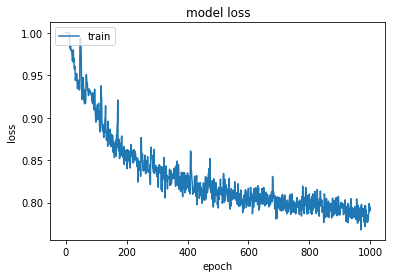

In [56]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

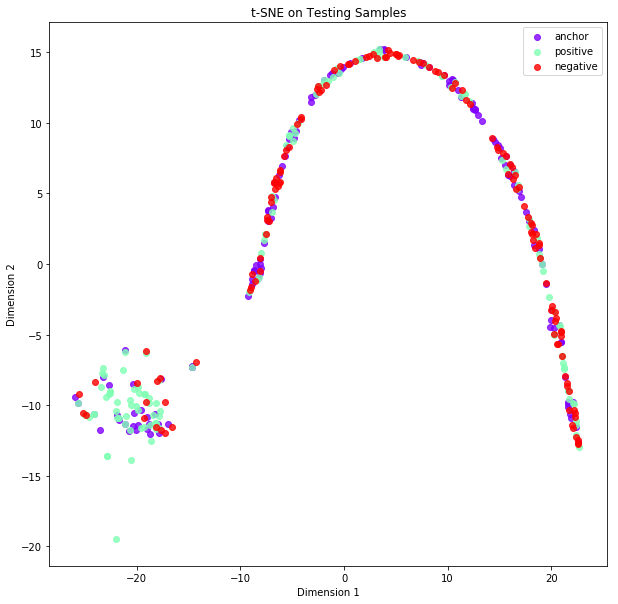

CPU times: user 2.97 s, sys: 1.34 s, total: 4.31 s
Wall time: 3.33 s


In [57]:
%%time
baseline.display_embed_space(similarity_model, 128)

In [59]:
name = 'baseline_1000epoch_10steps_512batch(eclipse)'
Baseline.save_model('', similarity_model, name)

Saved model to disk
